#This project aims to build a predictive model to assess the risk of Metabolic Syndrome using demographic, biometric, and lifestyle data. The goal is to assist healthcare providers in early identification and intervention.


In [11]:
# 0. Setup relevant libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

import xgboost as xgb
from xgboost import XGBClassifier


In [13]:
# 1. LOAD DATA
df = pd.read_csv('metabolic_risk_data.csv')


In [15]:
# 2. EXPLORE
df.head()

,seqn,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
0,62161,22,Male,Single,8200.0,White,81.0,23.3,0,3.88,4.9,92,41,84,0
1,62164,44,Female,Married,4500.0,White,80.1,23.2,0,8.55,4.5,82,28,56,0
2,62169,21,Male,Single,800.0,Asian,69.6,20.1,0,5.07,5.4,107,43,78,0
3,62172,43,Female,Single,2000.0,Black,120.4,33.3,0,5.22,5.0,104,73,141,0
4,62177,51,Male,Married,NaN,Asian,81.1,20.1,0,8.13,5.0,95,43,126,0


In [17]:
df.tail()


,seqn,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
2396,71901,48,Female,Married,1000.0,Other,NaN,59.7,0,22.11,5.8,152,57,107,0
2397,71904,30,Female,Single,2000.0,Asian,NaN,18.0,0,2.90,7.9,91,90,91,0
2398,71909,28,Male,Single,800.0,MexAmerican,100.8,29.4,0,2.78,6.2,99,47,84,0
2399,71911,27,Male,Married,8200.0,MexAmerican,106.6,31.3,0,4.15,6.2,100,41,124,1
2400,71915,60,Male,Single,6200.0,White,106.6,27.5,0,12.82,5.2,91,36,226,1


In [19]:
df.isnull().sum().sort_values(ascending=False).head()

Marital      208
Income       117
WaistCirc     85
BMI           26
Sex            0
dtype: int64

<Axes: >

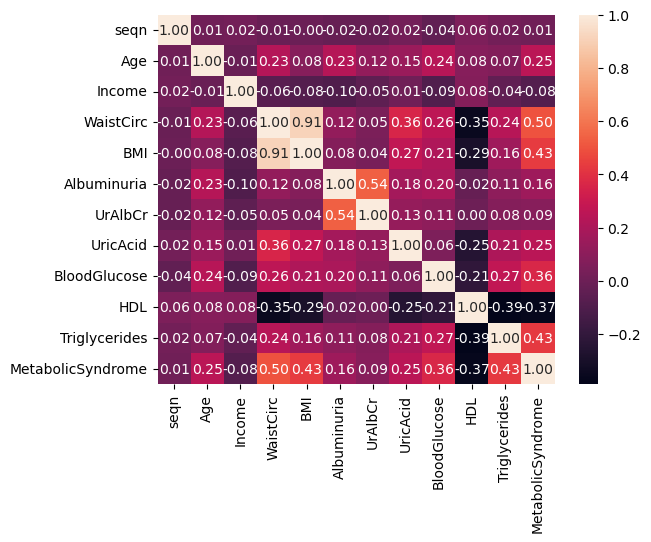

In [21]:
# 3. EDA
sns.histplot(df['Age'], kde=True)
sns.boxplot(x='MetabolicSyndrome', y='BMI', data=df)
sns.heatmap(df.select_dtypes(include=['float64', 'int64']).corr(), annot=True, fmt='.2f')

In [22]:
# 4. FEATURE ENGINEERING
# Encode categoricals
df['Marital'] = df['Marital'].map({'Single': 1, 'Married': 0, 'NaN':3, 'Other':4})
df['Sex'] = df['Sex'].map({'Male': 1, 'Female': 0})
df['Race'] = df['Race'].map({
    'White': 0,
    'Black': 1,
    'Hispanic': 2,
    'Asian': 3,
    'NaN': 4,
    'Other': 5
})

In [23]:
# Drop rows where target is missing
df = df[df['MetabolicSyndrome'].notnull()]

In [27]:
# 5. SPLIT FEATURES AND TARGET
X = df.drop("MetabolicSyndrome", axis=1)
y = df["MetabolicSyndrome"]

In [29]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [31]:
# 6. MODELING WITH XGBOOST
xgb_model = XGBClassifier(eval_metric='logloss')
xgb_model.fit(X_train, y_train);

In [33]:
# 6. PREDICTIONS
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]

In [35]:
# 7. EVALUATION
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.94      0.92       324
           1       0.86      0.77      0.81       157

    accuracy                           0.89       481
   macro avg       0.88      0.86      0.87       481
weighted avg       0.88      0.89      0.88       481

Confusion Matrix:
 [[305  19]
 [ 36 121]]
ROC-AUC Score: 0.9644373673036093


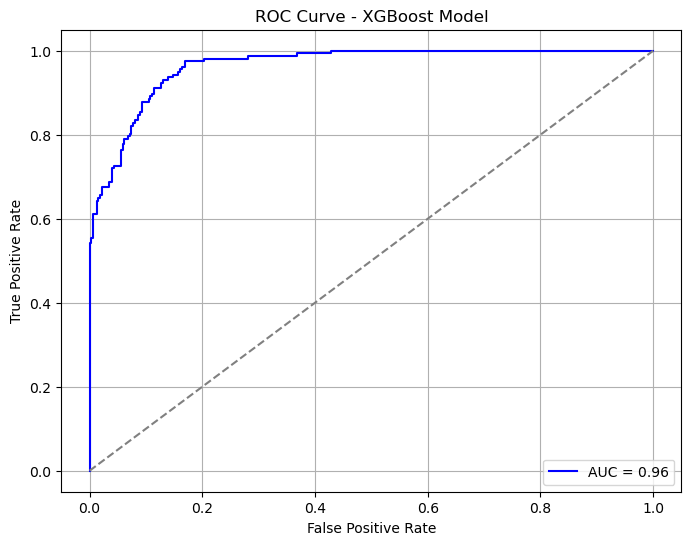

In [37]:
# 8. PLOT ROC CURVE
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc_score(y_test, y_proba):.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost Model')
plt.legend()
plt.grid()
plt.show()

In [47]:
# CREATE AN APP
import pickle

# Save trained model
with open("model.pkl", "wb") as f:
    pickle.dump(xgb_model, f)